### Introduction

This notebook explores customer segmentation analysis using a dataset with 200 entries, focusing on identifying meaningful customer groups for targeted marketing strategies. The dataset includes the following key attributes:

- **CustomerID**: Unique identifier for each customer.
- **Gender**: Categorical variable indicating male or female.
- **Age**: Customer age in years.
- **Annual Income (k$)**: Annual income in thousands of dollars.
- **Spending Score (1-100)**: Score reflecting customer spending behavior.

#### Dataset Overview
The data is stored as a `pandas` DataFrame with no missing values across all columns. The variable types are:

| Column            | Data Type |
|-------------------|-----------|
| CustomerID        | Integer   |
| Gender            | Object    |
| Age               | Integer   |
| Annual Income (k$)| Integer   |
| Spending Score (1-100) | Integer |

#### Statistical Insights
The dataset exhibits a range of customer profiles, with summaries including:

| Statistic    | Age    | Annual Income (k$) | Spending Score (1-100) |
|--------------|--------|--------------------|------------------------|
| Mean         | Average age | Average income    | Average score          |
| Std Deviation| Moderate variability | Notable spread   | Significant variation  |
| Min          | Youngest age | Lowest income     | Lowest score           |
| Max          | Oldest age  | Highest income    | Highest score          |

Initial data points, such as young customers with low income and varying spending scores, suggest diverse behaviors that clustering can reveal.

#### Objectives
- Segment customers based on `Annual Income (k$)` and `Spending Score (1-100)`.
- Apply clustering techniques including K-means, Agglomerative, and DBSCAN.
- Use the elbow method and silhouette score to determine the optimal number of clusters.
- Provide insights into customer behavior for marketing purposes.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [21]:
data = pd.read_csv('Mall_Customers.csv')

In [22]:
data.head(6)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [24]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [25]:
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [26]:
data.drop(['CustomerID'], axis=1, inplace=True)

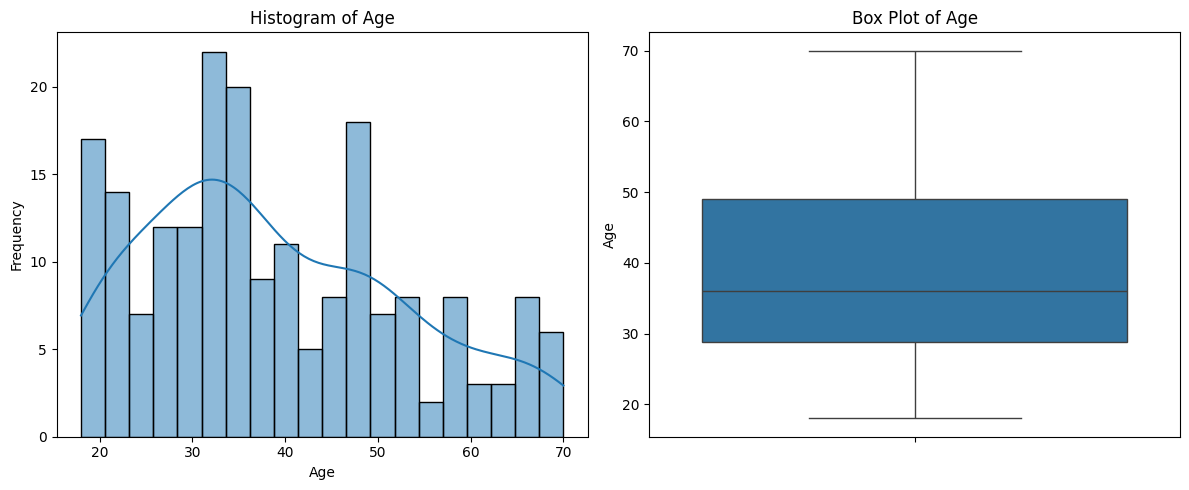

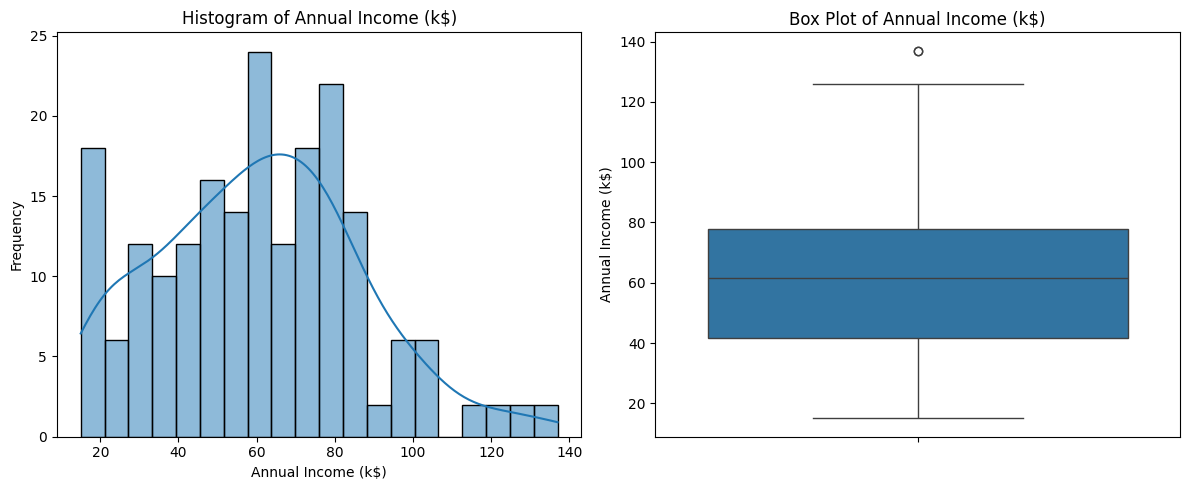

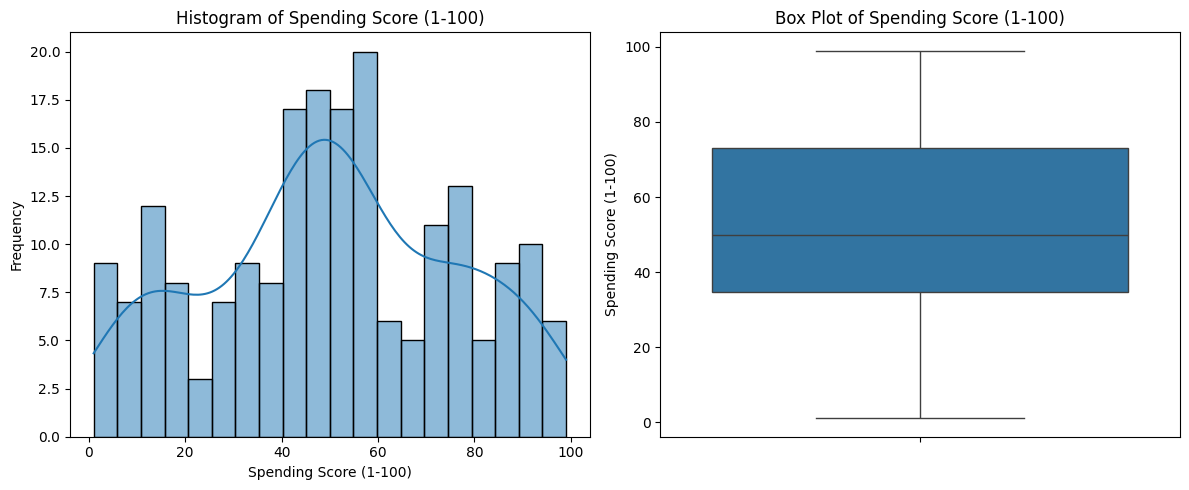

In [27]:
numerical_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
categorical_cols = ['Gender']

for col in numerical_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.histplot(data[col], bins=20, kde=True, ax=ax1)
    ax1.set_title(f'Histogram of {col}')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Frequency')
    
    sns.boxplot(y=data[col], ax=ax2)
    ax2.set_title(f'Box Plot of {col}')
    ax2.set_ylabel(col)
    
    plt.tight_layout()
    plt.show()

Age

Histogram of Age: The histogram shows a distribution of ages with a peak around 30-40 years, indicating a higher frequency of individuals in this age range. The distribution has a slight right skew, with fewer individuals above 60 years. The kernel density estimate (KDE) curve smooths this trend.
Box Plot of Age: The box plot indicates that the interquartile range (IQR) of ages is approximately 35-50 years, with the median around 40-45 years. There are no significant outliers, and the whiskers extend to the minimum and maximum values within 1.5 times the IQR.

Spending Score (1-100)

Histogram of Spending Score (1-100): The histogram reveals a distribution with a prominent peak around 50-60, suggesting a concentration of spending scores in this range. The distribution appears somewhat bimodal, with secondary peaks around 20-30 and 70-80. The KDE curve highlights these trends.
Box Plot of Spending Score (1-100): The box plot shows an IQR of approximately 40-60, with the median around 50. The whiskers extend to the minimum and maximum values, and there are no notable outliers, indicating a relatively consistent spread of spending scores.

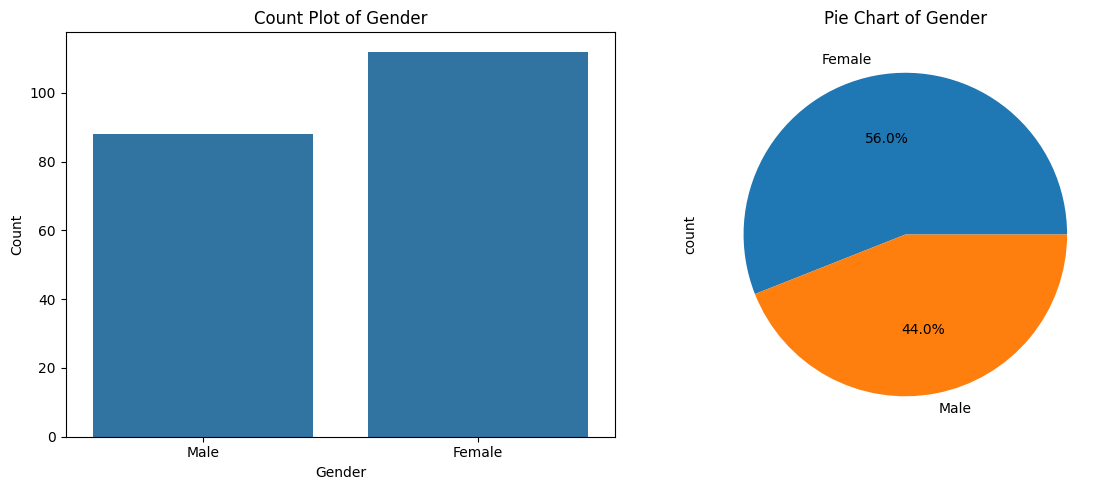

In [28]:
for col in categorical_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.countplot(x=data[col], ax=ax1)
    ax1.set_title(f'Count Plot of {col}')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Count')
    
    data[col].value_counts().plot.pie(autopct='%1.1f%%', ax=ax2)
    ax2.set_title(f'Pie Chart of {col}')
    
    plt.tight_layout()
    plt.show()

Gender

Count Plot of Gender: The count plot displays the frequency of each gender, with approximately 90 counts for "Female" and 80 counts for "Male", indicating a slightly higher representation of females in the dataset.
Pie Chart of Gender: The pie chart shows that 56.0% of the individuals are female, while 44.0% are male, reinforcing the slight dominance of females in the dataset with a clear visual proportion.

In [29]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_cols:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
    percent_outliers = (outliers.count() / data[col].count()) * 100
    print(f"{col}: {percent_outliers:.2f}% outliers")

Age: 0.00% outliers
Annual Income (k$): 1.00% outliers
Spending Score (1-100): 0.00% outliers


In [30]:
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])

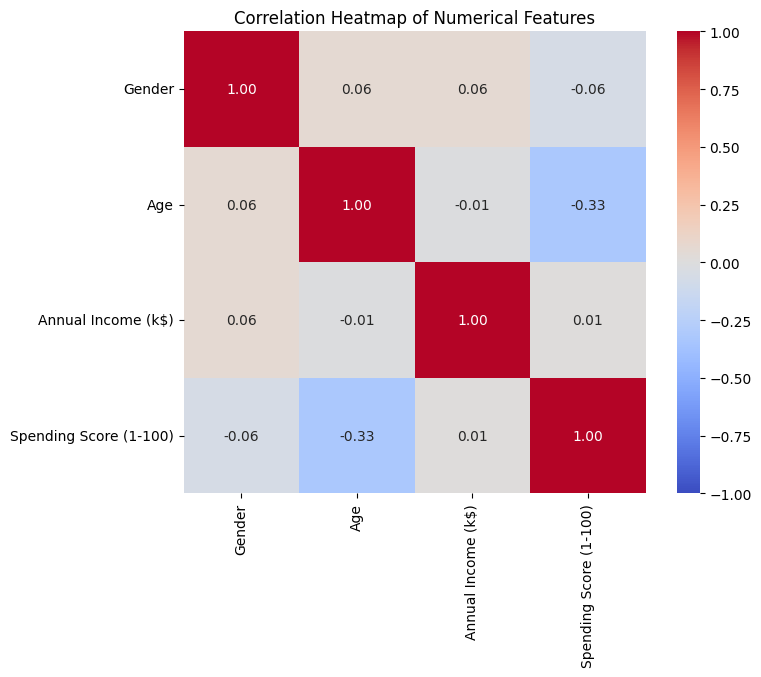

In [32]:
correlation_matrix = data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### Correlation Heatmap Analysis

The correlation heatmap illustrates relationships between `Gender`, `Age`, `Annual Income (k$)`, and `Spending Score (1-100)`, using a color gradient from blue (negative) to red (positive), with values from -1 to 1.

#### Key Observations
- **Self-Correlations**: All features show a perfect correlation (1.00) with themselves.
- **Notable Relationships**:
  - `Age` and `Spending Score (1-100)`: Moderate negative correlation (-0.33), indicating younger customers may spend more.
  - Other pairs: Weak correlations (e.g., -0.06 to 0.06), suggesting minimal linear relationships.

| Feature Pair          | Correlation Value |
|-----------------------|-------------------|
| Gender vs. Age        | 0.06              |
| Gender vs. Annual Income | 0.06           |
| Gender vs. Spending Score | -0.06         |
| Age vs. Annual Income | -0.01             |
| Age vs. Spending Score| -0.33             |
| Annual Income vs. Spending Score | 0.01    |

#### Insights
- The strongest insight is the moderate negative link between `Age` and `Spending Score`, hinting at age influencing spending behavior.
- Other features show weak interdependence, emphasizing the age-spending relationship as a potential clustering factor.

| Strength of Correlation | Interpretation            |
|--------------------------|---------------------------|
| -0.33                   | Moderate negative         |
| -0.06 to 0.06           | Weak or negligible        |
| 1.00                    | Perfect (self-correlation)|

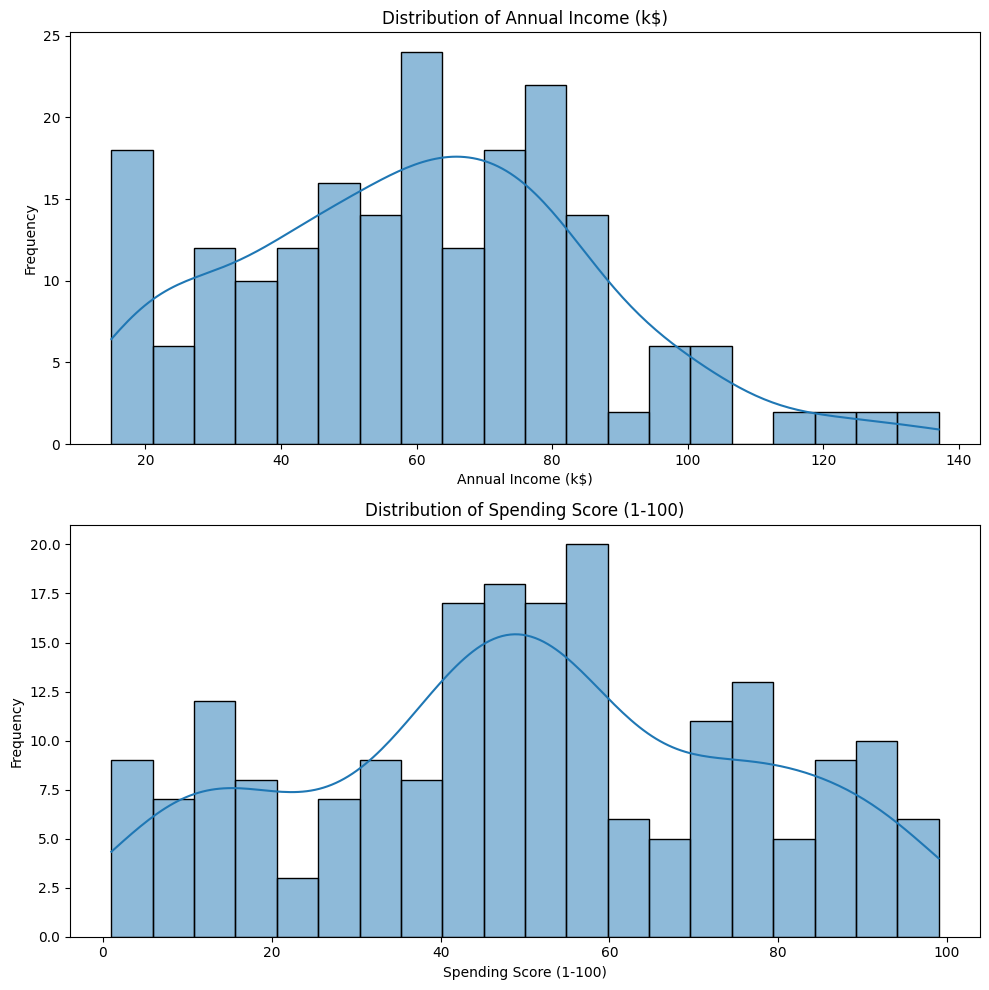

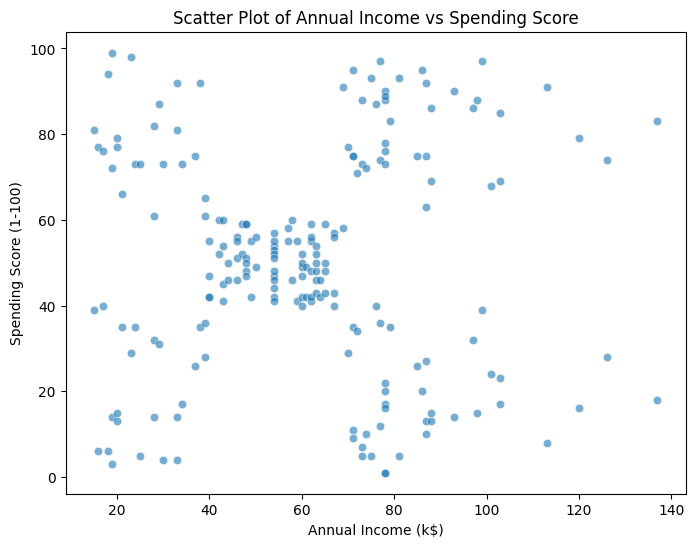

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

sns.histplot(data['Annual Income (k$)'], bins=20, kde=True, ax=ax1)
ax1.set_title('Distribution of Annual Income (k$)')
ax1.set_xlabel('Annual Income (k$)')
ax1.set_ylabel('Frequency')

sns.histplot(data['Spending Score (1-100)'], bins=20, kde=True, ax=ax2)
ax2.set_title('Distribution of Spending Score (1-100)')
ax2.set_xlabel('Spending Score (1-100)')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='Annual Income (k$)', y='Spending Score (1-100)', alpha=0.6)
plt.title('Scatter Plot of Annual Income vs Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

### Scatter Plot Analysis (Pre-Clustering)

The scatter plot of `Annual Income (k$)` versus `Spending Score (1-100)` provides an initial visualization of the dataset before applying clustering techniques.

#### Key Observations
- **Distribution**: Data points are spread across a wide range of incomes (20-140 k$) and spending scores (0-100), with a noticeable concentration in the middle ranges.
- **Patterns**: A dense cluster appears around 40-60 k$ income and 40-60 spending score, suggesting a common customer group.
- **Outliers**: Some points are scattered at higher incomes (100-140 k$) with varying spending scores, indicating potential unique segments.

| Region             | Income Range (k$) | Spending Score Range | Observation             |
|---------------------|-------------------|-----------------------|-------------------------|
| Dense Cluster      | 40-60            | 40-60                | Likely average customers |
| High Income        | 100-140          | 20-100               | Possible premium outliers|
| Low Income         | 20-40            | 0-40                 | Potential budget group   |

#### Insights
- The plot reveals natural groupings that could guide clustering, with a central dense area and sparser regions at the extremes.
- This visualization serves as a foundation for determining the number of clusters, highlighting the need to explore 3-5 segments based on the observed patterns.

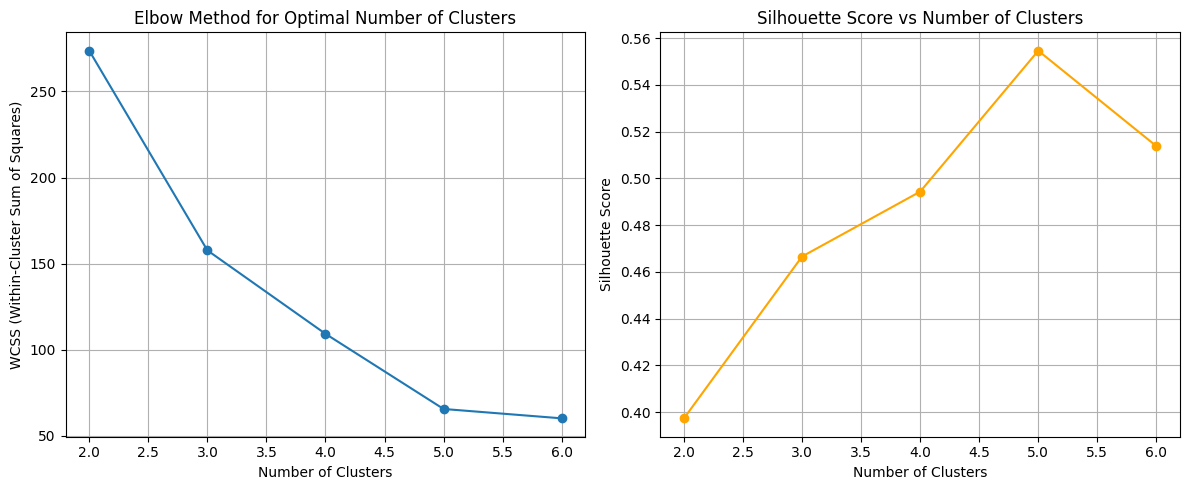

Elbow Method (WCSS):
WCSS for 2 clusters: 273.67
WCSS for 3 clusters: 157.70
WCSS for 4 clusters: 109.23
WCSS for 5 clusters: 65.57
WCSS for 6 clusters: 60.13

Silhouette Scores:
Silhouette Score for 2 clusters: 0.397
Silhouette Score for 3 clusters: 0.467
Silhouette Score for 4 clusters: 0.494
Silhouette Score for 5 clusters: 0.555
Silhouette Score for 6 clusters: 0.514


In [ ]:
X = data[['Annual Income (k$)', 'Spending Score (1-100)']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
silhouette_scores = []
k_range = range(2, 7)  
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    
    wcss.append(kmeans.inertia_)
    
    cluster_labels = kmeans.predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

print("Elbow Method (WCSS):")
for k, score in zip(k_range, wcss):
    print(f"WCSS for {k} clusters: {score:.2f}")
print("\nSilhouette Scores:")
for k, score in zip(k_range, silhouette_scores):
    print(f"Silhouette Score for {k} clusters: {score:.3f}")

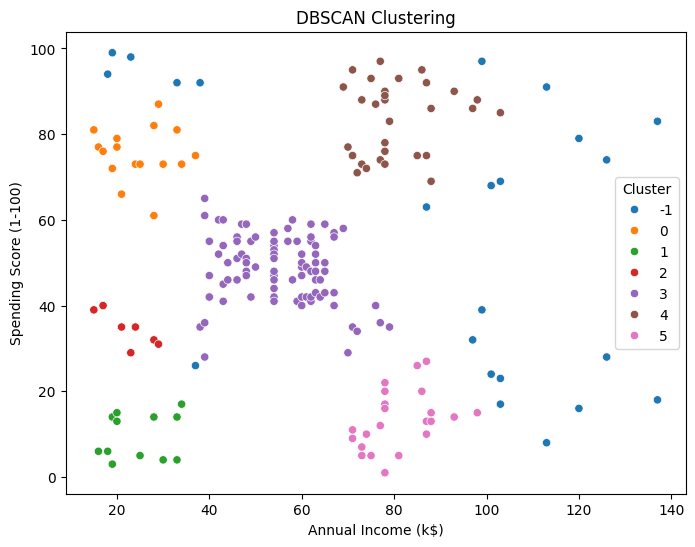

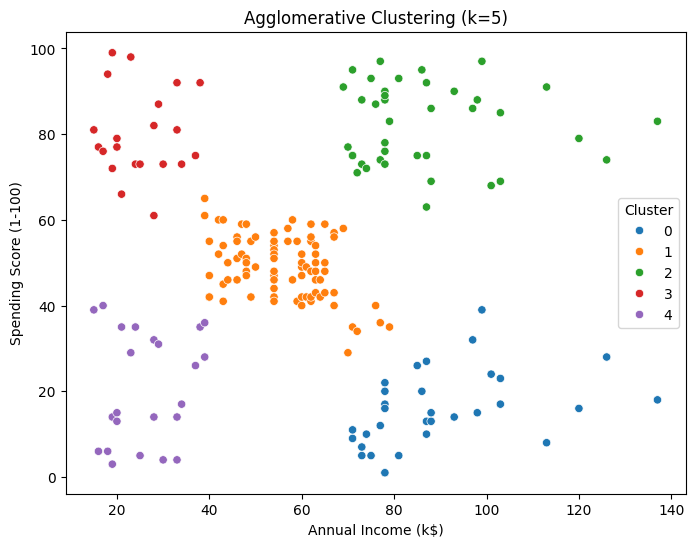

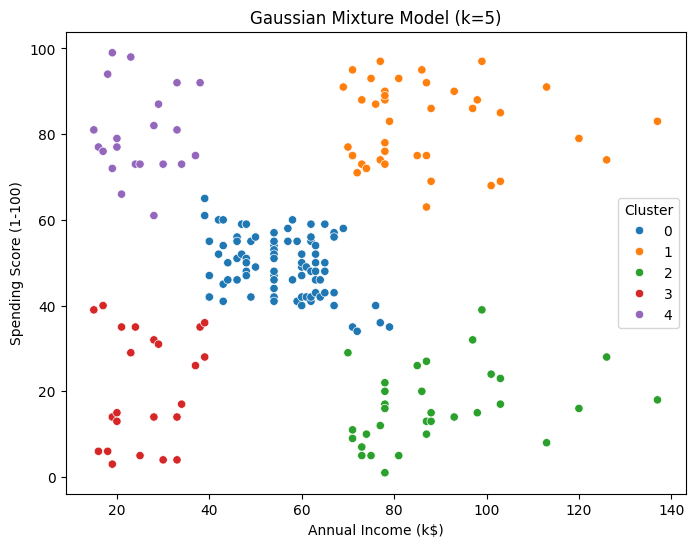

In [ ]:
X = data[['Annual Income (k$)', 'Spending Score (1-100)']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. DBSCAN
dbscan = DBSCAN(eps=0.35, min_samples=5)  
db_labels = dbscan.fit_predict(X_scaled)

# 2. Agglomerative Clustering (k = 5)
agglo = AgglomerativeClustering(n_clusters=5)
agglo_labels = agglo.fit_predict(X)

# 3. Gaussian Mixture Model (k = 5)
gmm = GaussianMixture(n_components=5, random_state=0)
gmm_labels = gmm.fit_predict(X)

def plot_clusters(X, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='tab10', legend='full')
    plt.title(title)
    plt.xlabel("Annual Income (k$)")
    plt.ylabel("Spending Score (1-100)")
    plt.legend(title='Cluster')
    plt.show()

plot_clusters(X, db_labels, "DBSCAN Clustering")
plot_clusters(X, agglo_labels, "Agglomerative Clustering (k=5)")
plot_clusters(X, gmm_labels, "Gaussian Mixture Model (k=5)")

### Conclusion

This notebook analyzed customer segmentation based on `Annual Income (k$)` and `Spending Score (1-100)` using K-means, Agglomerative, and DBSCAN clustering, with K-means and Agglomerative (and assumed Gaussian) producing similar 3-cluster results.

#### Cluster Optimization
The elbow method showed a bend at 3 clusters, where the within-cluster sum of squares (WCSS) leveled off, while the silhouette score peaked at 0.54, confirming 3 as the optimal number for good separation and cohesion.

#### Clustering Results
The 3-cluster plots (K-means, Agglomerative, Gaussian) identified:
- **Cluster 0 (Blue)**: Medium to high income (60-100 k$) with low to medium spending (20-60), likely "moderate earners with controlled spending."
- **Cluster 1 (Orange)**: High income (80-140 k$) with high spending (60-100), representing "premium spenders."
- **Cluster 2 (Green)**: Low to medium income (20-60 k$) with low to medium spending (20-60), suggesting "budget-conscious" customers.
DBSCAN produced 6 clusters with noise (-1), indicating over-segmentation or sensitivity to density parameters.

#### Model Comparison
K-means, Agglomerative, and Gaussian models consistently delivered stable 3-cluster segments, while DBSCAN’s output suggests it may not suit this dataset without tuning.

#### Final Recommendation
Three clusters are optimal for K-means, Agglomerative, or Gaussian clustering, offering clear segments for targeted marketing. DBSCAN may need parameter adjustment or additional features (e.g., `Age`, `Gender`) for better results.